# Image class classification of garbage to identify the correct bin in Manningham

## Planning

### Aim:
The aim is to create a neural network that can use an image of some piece of garbage and identify which bin it should be placed into based on manninghams local garbage policies.

#### Manningham's Bins:

<p>
Manningham has <b>three</b> bin types:
    
<ul>
<li> <b>Red</b> General Garbage Bin</li>
<li> <b>Yellow</b> Recycling Bin</li>
<li> <b>Green</b> FOGO Bin</li>
</ul>
</p>

In the future I will just be referring to these bins by color.

### Model design
I intend on creating a <b>convnet</b> which takes an input of an image and an output of the type of rubbish, which will then be used to assign the rubbish to a bin via non-machine learning systems. This implementation allows for more specific training with teaching the type of trashing, making it more flexible if recycling guidelines change in the future.

<ul>
<li> The <b>input</b> is an <b>image</b>.</li>
<li> The <b>target class</b> is the type of <b>garbage</b>.</li>
<li> The <b>final output</b> is the <b>type of bin</b> the garbage should be placed into</li>
</ul>




#### Dataset

The dataset I plan on using is the <b>"Garbage Classification" dataset from Kaggle</b> <https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification>

Except from the page: "The Garbage Classification <b>Dataset contains 6 classifications</b>: cardboard (393), glass (491), metal (400), paper(584), plastic (472) and trash(127)."

Of these classes (the target classes) I will outline which bin contains which piece of trash from the dataset.


<b>Red Bin Contains</b>
<ul>
<li> General Trash</li>
<li> Plastic</li>
</ul>


<b>Yellow Bin Contains</b>

<ul>
<li> Cardboard</li>
<li> Glass</li>
<li> Metal</li>
<li> Paper</li>
</ul>


<b>Green Bin Contains</b>

<ul>
<li> Nothing from this dataset and this bin will be not included in the future of this task</li>
<li> Is intended to contain food scraps and plant matter</li>
</ul>



Due to the nature of the dataset, splitting it into types of trash will also help me avoid unbalanced training data, as it will be easier to even out the number of samples for the individual trash types as opposed to samples from each bin.

#### Labels
The data is already pre-labeled for my use.

#### Number of samples per class

I plan on using <b>NUM_SAMPLES samples per class</b> with a <b>60/20/20% test/train/validation split</b>. I selected this value as it will involve me using data augmentation, but not to an excessive degree, with 3 variations of each image being required for general trash (only 127 unique samples).

I believe that, as this is a fairly simple classification task, using smaller amounts of samples (mid-hundreds) will be sufficient for the convnet.

## Implimentation

### Data preparation

In this code block I import all images, augmenting all of them, if I can not get to 480 images I begin picking random images out and augmenting them till I have the 480 samples per class.

### Data Augmentation

I only read after I'd implimented it that a augmentation pipeline is the C task, I have included the comparison without augmentation later on.

In [3]:
%%time

import os
import random
import tensorflow as tf

random.seed(42)

NUM_SAMPLES = 480

data_folder = 'Garbage classification'
classes = os.listdir(data_folder)
output_folder = 'processed_data_augmented'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Rotation model
rotate = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=(1/12, 1/12)),
    tf.keras.layers.RandomZoom(0.2)
])

def augmentation_pipeline(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = rotate(image)
    image = tf.cast(image * 255.0, tf.uint8)
    return image



for class_name in classes:
    class_path = os.path.join(data_folder, class_name)
    images = [os.path.join(class_path, image) for image in os.listdir(class_path) if image.endswith('.jpg')]
    output_class_folder = os.path.join(output_folder, class_name)
    if not os.path.exists(output_class_folder):
        os.makedirs(output_class_folder)
    
    augmented_data_count = 0
    while augmented_data_count < NUM_SAMPLES:
        image_path = random.choice(images)
        original_image = tf.io.read_file(image_path)
        original_image = tf.image.decode_jpeg(original_image, channels=3)
        
        # Apply augmentation
        augmented_image = augmentation_pipeline(original_image)
        
        # Save the augmented image
        augmented_image_path = os.path.join(output_class_folder, f'{augmented_data_count}.jpg')
        tf.io.write_file(augmented_image_path, tf.image.encode_jpeg(augmented_image))
        augmented_data_count += 1

print("done")

done
CPU times: total: 3min 18s
Wall time: 1min 47s


#### Profiler - Could not get it working properly - wasn't quite sure how to apply it

In [20]:
rotate = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=(1/12, 1/12)),
    tf.keras.layers.RandomZoom(0.2)
])

def augmentation_pipeline(image):
    with tf.profiler.experimental.Trace('cast_to_float'):
        image = tf.cast(image, tf.float32) / 255.0

    with tf.profiler.experimental.Trace('random_flip_left_right'):
        image = tf.image.random_flip_left_right(image)

    with tf.profiler.experimental.Trace('random_flip_up_down'):
        image = tf.image.random_flip_up_down(image)

    with tf.profiler.experimental.Trace('rotate'):
        image = rotate(image)  # Assuming rotate is defined elsewhere

    with tf.profiler.experimental.Trace('cast_to_uint8'):
        image = tf.cast(image * 255.0, tf.uint8)

    return image

# Assuming the use of TensorFlow 2.x and its profiler API
logdir = './logs'
tf.profiler.experimental.start(logdir, tf.profiler.experimental.ProfilerOptions())

# Example usage with a dummy image
dummy_image = tf.random.uniform(shape=[256, 256, 3], minval=0, maxval=256, dtype=tf.int32)
augmented_image = augmentation_pipeline(tf.cast(dummy_image, tf.uint8))

# Running the function to profile
for _ in range(1000):  # Adjusted range to start from 0 for better practice
    augmented_image = augmentation_pipeline(tf.cast(dummy_image, tf.uint8))

# Stopping the profiler
tf.profiler.experimental.stop()

In [36]:
%reset -f

### Test Train Validation Split

In [37]:
%%time
import tensorflow as tf

dataset_path = 'processed_data'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32)

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

CPU times: total: 0 ns
Wall time: 0 ns
Found 2880 files belonging to 6 classes.
Using 2304 files for training.
Found 2880 files belonging to 6 classes.
Using 576 files for validation.


In [42]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.15),  
    tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_regularizer=l2(0.25)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(6) 
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True 
)

In [43]:
%%time
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=10
    )

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 613ms/step - accuracy: 0.1977 - loss: 15.2438 - val_accuracy: 0.3785 - val_loss: 3.1527
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 650ms/step - accuracy: 0.4508 - loss: 2.5776 - val_accuracy: 0.4705 - val_loss: 1.7987
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 606ms/step - accuracy: 0.5014 - loss: 1.6152 - val_accuracy: 0.5174 - val_loss: 1.3836
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 624ms/step - accuracy: 0.5365 - loss: 1.3273 - val_accuracy: 0.5278 - val_loss: 1.2658
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 593ms/step - accuracy: 0.6031 - loss: 1.1628 - val_accuracy: 0.5660 - val_loss: 1.2416
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 633ms/step - accuracy: 0.6067 - loss: 1.1395 - val_accuracy: 0.6007 - val_loss: 1.1769
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 628ms/step - accuracy: 0.6597 - loss: 1.0169 - val_accuracy: 0.5885 - val_loss: 1.1420
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 588ms/step - ac

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step
              precision    recall  f1-score   support

           0       0.87      0.70      0.78        99
           1       0.50      0.41      0.45        99
           2       0.67      0.46      0.55        91
           3       0.48      0.75      0.59        93
           4       0.61      0.51      0.55        89
           5       0.65      0.83      0.73       105

    accuracy                           0.61       576
   macro avg       0.63      0.61      0.61       576
weighted avg       0.63      0.61      0.61       576



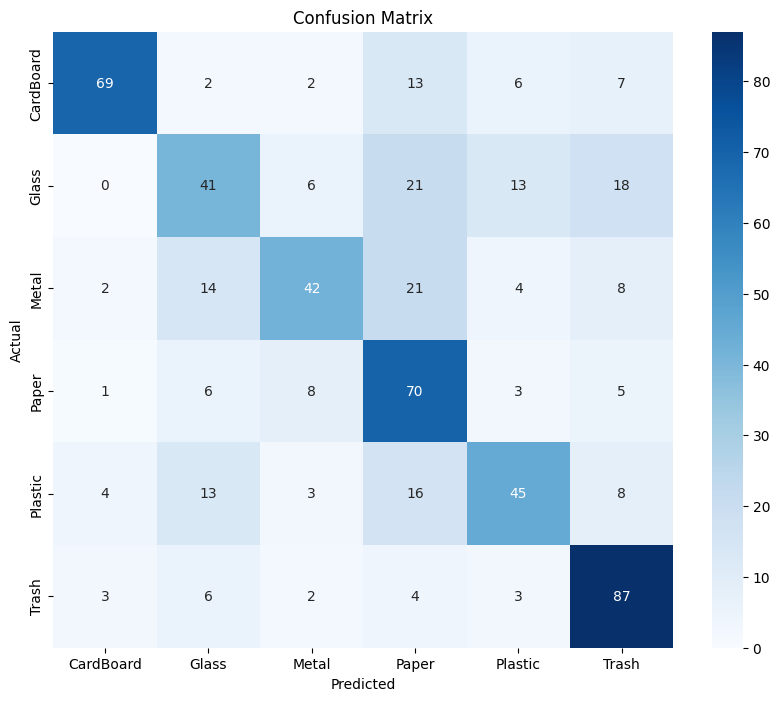

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = ["CardBoard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

# Predicting on validation dataset
predictions = model.predict(validation_dataset)

# Getting true labels
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Converting predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Printing classification report
print(classification_report(true_labels, predicted_labels))

# Plotting confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

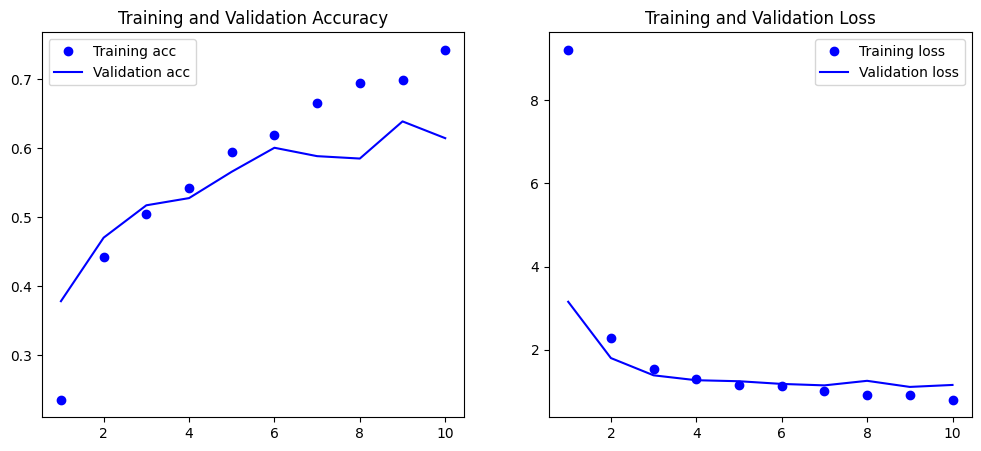

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Most metrics are around 61%, which isn't great, although it is with 6 target classes, which makes it slightly less bad sounding than if it was binary. Lets convert it to bins to identify if I succeeded with my goal.

### Converting trash training data to bin training data.

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step
Classification Report for Bin Labels:
              precision    recall  f1-score   support

  Yellow Bin       0.86      0.83      0.85       382
     Red Bin       0.69      0.74      0.71       194

    accuracy                           0.80       576
   macro avg       0.78      0.78      0.78       576
weighted avg       0.80      0.80      0.80       576



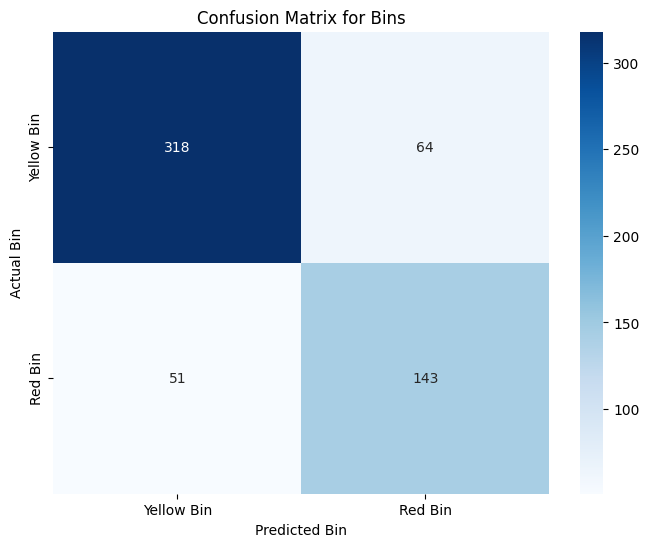

In [48]:
class_names = ["CardBoard", "Glass", "Metal", "Paper", "Plastic", "Trash"]
bin_names = ["Yellow Bin", "Red Bin"]

# Mapping class labels to bin labels
class_to_bin = {
    "CardBoard": "Yellow Bin",
    "Glass": "Yellow Bin",
    "Metal": "Yellow Bin",
    "Paper": "Yellow Bin",
    "Plastic": "Red Bin",
    "Trash": "Red Bin"
}

# Function to convert class labels to bin labels
def convert_to_bins(labels, class_to_bin, class_names):
    bin_labels = [class_to_bin[class_names[label]] for label in labels]
    return np.array([bin_names.index(bin_label) for bin_label in bin_labels])

# Predicting on validation dataset
predictions = model.predict(validation_dataset)

# Getting true labels
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Converting predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Converting true and predicted class labels to bin labels
true_bin_labels = convert_to_bins(true_labels, class_to_bin, class_names)
predicted_bin_labels = convert_to_bins(predicted_labels, class_to_bin, class_names)

# Printing classification report for bin labels
print("Classification Report for Bin Labels:")
print(classification_report(true_bin_labels, predicted_bin_labels, target_names=bin_names))

# Plotting confusion matrix for bin labels
cm_bin = confusion_matrix(true_bin_labels, predicted_bin_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Blues", xticklabels=bin_names, yticklabels=bin_names)
plt.xlabel('Predicted Bin')
plt.ylabel('Actual Bin')
plt.title('Confusion Matrix for Bins')
plt.show()

### Model performance analysis

## Model without augmentation

I repeat the exact same process but I remove the augmentations entirely.

In [50]:
%reset -f

In [52]:
%%time

import os
import random
import tensorflow as tf

random.seed(42)

NUM_SAMPLES = 480

data_folder = 'Garbage classification'
classes = os.listdir(data_folder)
output_folder = 'processed_data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in classes:
    class_path = os.path.join(data_folder, class_name)
    images = [os.path.join(class_path, image) for image in os.listdir(class_path) if image.endswith('.jpg')]
    output_class_folder = os.path.join(output_folder, class_name)
    if not os.path.exists(output_class_folder):
        os.makedirs(output_class_folder)
    
    data_count = 0
    while data_count < NUM_SAMPLES:
        image_path = random.choice(images)
        original_image = tf.io.read_file(image_path)
        original_image = tf.image.decode_jpeg(original_image, channels=3)
        

        data_image_path = os.path.join(output_class_folder, f'{data_count}.jpg')
        tf.io.write_file(data_image_path, tf.image.encode_jpeg(original_image))
        data_count += 1

print("done")

CPU times: total: 0 ns
Wall time: 0 ns
done


In [53]:
%reset -f

In [56]:
%%time
import tensorflow as tf

dataset_path = 'processed_data'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32)

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 2880 files belonging to 6 classes.
Using 2304 files for training.
Found 2880 files belonging to 6 classes.
Using 576 files for validation.
CPU times: total: 2.3 s
Wall time: 999 ms


In [57]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.15),  
    tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_regularizer=l2(0.25)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(6) 
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True 
)

In [58]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.15),  
    tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_regularizer=l2(0.25)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(6) 
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True 
)

In [59]:
%%time
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=10
    )

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 648ms/step - accuracy: 0.2579 - loss: 14.1893 - val_accuracy: 0.3490 - val_loss: 2.4995
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 627ms/step - accuracy: 0.4636 - loss: 1.9932 - val_accuracy: 0.5538 - val_loss: 1.3716
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 637ms/step - accuracy: 0.5723 - loss: 1.2962 - val_accuracy: 0.6042 - val_loss: 1.1917
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 719ms/step - accuracy: 0.6641 - loss: 1.0250 - val_accuracy: 0.6632 - val_loss: 1.0068
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 734ms/step - accuracy: 0.6951 - loss: 0.8979 - val_accuracy: 0.6910 - val_loss: 0.9467
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 651ms/step - accuracy: 0.7520 - loss: 0.7507 - val_accuracy: 0.7188 - val_loss: 0.9069
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 703ms/step - accuracy: 0.8004 - loss: 0.6449 - val_accuracy: 0.7951 - val_loss: 0.7279
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 667ms/step - accuracy: 0.8551 - loss: 0.5046 - val_acc

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        99
           1       0.72      0.74      0.73        99
           2       0.81      0.63      0.71        91
           3       0.88      0.84      0.86        93
           4       0.72      0.80      0.76        89
           5       0.83      0.95      0.89       105

    accuracy                           0.81       576
   macro avg       0.81      0.81      0.81       576
weighted avg       0.81      0.81      0.81       576



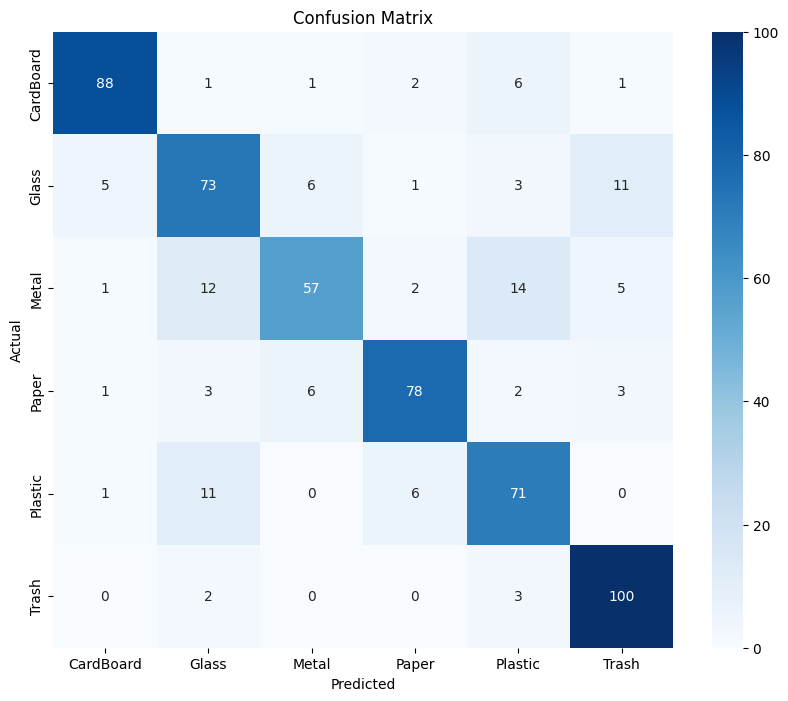

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = ["CardBoard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

# Predicting on validation dataset
predictions = model.predict(validation_dataset)

# Getting true labels
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Converting predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Printing classification report
print(classification_report(true_labels, predicted_labels))

# Plotting confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

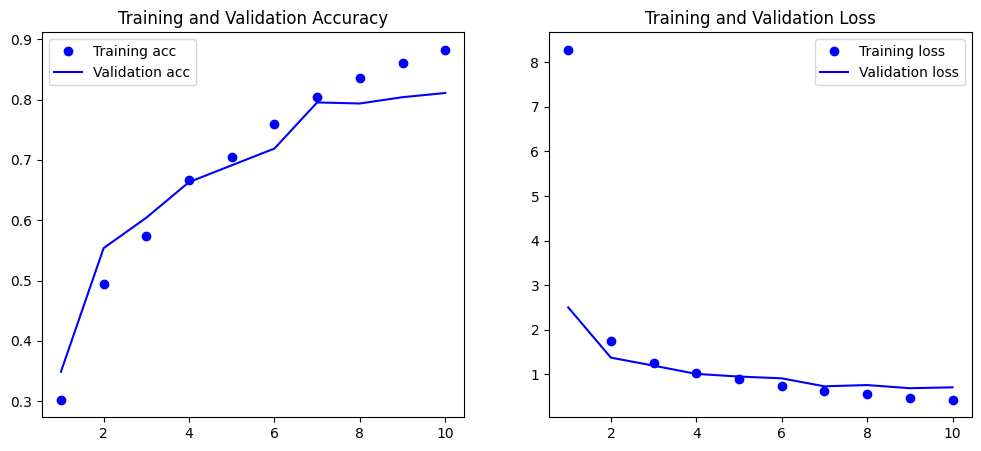

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Comparison and design flaws for experiment

The result of this where time spent was 7:30 and 8:08 for augmented and non-augmented respectively was that the non-augmented performed significantly better, notably in the trash data comparison where it was ~95% accurate which was when I realised the methodology for creating the data set can place the same data image in both test and train. I didn't think this was an issue when designing it, as I assumed that augmentations would be applied to mitigate this effect of damaging the test results. However, upon reviewing the Augmented confusion matrix, I found that the trash also had a high number of True positives, which leads me to believe that in the future, I would need to separate the datasets better to avoid the algorithm 'cheating'.

### Bin data conversion

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
Classification Report for Bin Labels:
              precision    recall  f1-score   support

  Yellow Bin       0.94      0.88      0.91       382
     Red Bin       0.79      0.90      0.84       194

    accuracy                           0.89       576
   macro avg       0.87      0.89      0.88       576
weighted avg       0.89      0.89      0.89       576



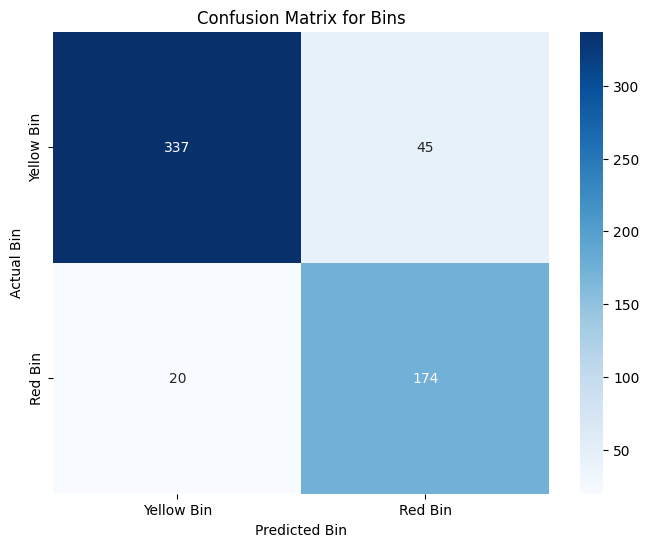

In [63]:
class_names = ["CardBoard", "Glass", "Metal", "Paper", "Plastic", "Trash"]
bin_names = ["Yellow Bin", "Red Bin"]

# Mapping class labels to bin labels
class_to_bin = {
    "CardBoard": "Yellow Bin",
    "Glass": "Yellow Bin",
    "Metal": "Yellow Bin",
    "Paper": "Yellow Bin",
    "Plastic": "Red Bin",
    "Trash": "Red Bin"
}

# Function to convert class labels to bin labels
def convert_to_bins(labels, class_to_bin, class_names):
    bin_labels = [class_to_bin[class_names[label]] for label in labels]
    return np.array([bin_names.index(bin_label) for bin_label in bin_labels])

# Predicting on validation dataset
predictions = model.predict(validation_dataset)

# Getting true labels
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Converting predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Converting true and predicted class labels to bin labels
true_bin_labels = convert_to_bins(true_labels, class_to_bin, class_names)
predicted_bin_labels = convert_to_bins(predicted_labels, class_to_bin, class_names)

# Printing classification report for bin labels
print("Classification Report for Bin Labels:")
print(classification_report(true_bin_labels, predicted_bin_labels, target_names=bin_names))

# Plotting confusion matrix for bin labels
cm_bin = confusion_matrix(true_bin_labels, predicted_bin_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Blues", xticklabels=bin_names, yticklabels=bin_names)
plt.xlabel('Predicted Bin')
plt.ylabel('Actual Bin')
plt.title('Confusion Matrix for Bins')
plt.show()

Once again the unaugmented data performs better due to poorly split dataset.

### I did not attempt to identify what was in common for most incorrect guesses